# Exploring OCD detection data

## Import Required Modules

In [1]:
%load_ext autoreload
%autoreload 2

## Import System tools

In [2]:
import os
import sys
import gc
import re
import cProfile
import warnings

## Importing libraries

In [3]:
from enum import Enum
from enum import IntEnum
import itertools

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.markers as markers
import seaborn as sns
import json
import pickle
from tabulate import tabulate

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.model_selection import train_test_split

## Global Variables

In [108]:
WINDOW_TIME = 7.6 # Seconds
FREQUENCY = 50 # 50Hz
WINDOW_SIZE = WINDOW_TIME*FREQUENCY
DIR = "/data/OCDetect_Export"
DROP_STATS = ["count"] # Stats to drop
IGNORE_LIST = [val for val in range(1,7)] # Ignore types
LABELS = ['Others','Routine HW', 'Compulsive HW']

## Setup

In [7]:
warnings.filterwarnings("ignore")

## Data Models

In [8]:
class HandWashingType(IntEnum):
    NoHandWash = 0
    Routine = 1
    Compulsive = 2

class CSVHeader(Enum):
    """Enum class CSV headers
    
     0   timestamp    float64
     1   datetime     object 
     2   acc x        float64
     3   acc y        float64
     4   acc z        float64
     5   gyro x       float64
     6   gyro y       float64
     7   gyro z       float64
     8   user yes/no  float64
     9   compulsive   float64
     10  urge         float64
     11  tense        float64
     12  ignore       int64  
     13  relabeled    int64  
    """
    TIMESTAMP = "timestamp"
    DATETIME = "datetime"
    ACC_X = "acc x"
    ACC_Y = "acc y"
    ACC_Z = "acc z"
    GYRO_X = "gyro x"
    GYRO_Y = "gyro y"
    GYRO_Z = "gyro z"
    HW = "user yes/no"
    COMPULSIVE_HW = "compulsive"
    TENSE = "tense"
    URGE ="urge"
    IGNORE = "ignore"
    RELABELED = "relabeled"

## Utils

### Directory Utils

In [9]:
# Function to get working data directory
def get_data_dir(subfolder = "OCDetect_Export"):
    # current working directory
    current_dir = os.getcwd()
    # data directory
    data_dir = os.path.join(current_dir, "data/"+subfolder)
    return data_dir

# Function to get csv files from folder
def get_files_names(path):
     # Check if exists
    if not os.path.exists(path):
        raise  FileNotFoundError(f"Path does not exists: {path}")
    
    files = os.listdir(path)
    
    files_names = [item for item in files if item.endswith(".csv")]
    
    return files_names
        
# Function to create folder and return path
def create_folder(name):
    
    folder_path = get_data_dir(name)
    
     # Create path if doesn't exists
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(folder_path, " Directory created.")
    
    return folder_path

### Dataframe Utils

In [10]:
# Read csv file
def read_csv_file(filename, subfolder="OCDetect_Export"):
    
    path = os.path.join(get_data_dir(subfolder),filename)
    
    try:
        df = pd.read_csv(path)
        print("CSV file is readable.")
        return df
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        return None
    except pd.errors.EmptyDataError:
        print(f"Error: File '{filename}' is empty.")
        return None
    except pd.errors.ParserError:
        print(f"Error: File '{filename}' is corrupted or has parsing issues.")
        return None

# Get iterator of csv file reader.
def get_iterator(filename, chunksize=150):
    path = os.path.join(get_data_dir(),filename)
    
    try:
        df = pd.read_csv(filename, path)
        print("CSV file is readable.")
        return df
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        return None
    except pd.errors.EmptyDataError:
        print(f"Error: File '{filename}' is empty.")
        return None
    except pd.errors.ParserError:
        print(f"Error: File '{filename}' is corrupted or has parsing issues.")
        return None

# Function to get the csv files of the selected subjects
def filter_by(subject:int, files:list):
    
    selected_files = []
    
    # Regex pattern
    regex_pattern = r"OCDetect_(\d+)_"

    for file in files:
        match = re.search(regex_pattern, file)
        if match and int(match.group(1)) == subject:
            selected_files.append(file)

    return selected_files

# Function to print all rows of csv file
def print_rows(df_sensor, chunk=1000):
    for i in range(0, len(df_sensor), chunk):
        print(df_sensor.iloc[i:i+chunk])
        
# Functiont to calculate mean and var and quartiles
def save_to_csv(df_data, folder, file_name):
    
    folder_path = create_folder(folder)
    
    # Output File path
    file_path = os.path.join(folder_path, file_name.rsplit( ".", 1 )[0] + f"-{folder}.csv")
    
    # Save the updated DataFrame to a new CSV file
    try:
        df_data.to_csv(file_path, sep=",", index=False)
        print(f"DataFrame saved successfully to path: {file_path}.")
    except Exception as e:
        message = "Error encountered while saving the dataframe: " + str(e)
        raise Exception(msg)
    
    # release memory
    del df_data
    gc.collect()

# Function to get new header names from dataframe having rows and columns headers
def get_new_cols_header(df, column_first=True):
    
    # Safety check
    if df.empty:
        print("Argument Error")
        return
    
    # Get rows and cols headers
    row = df.index if column_first else df.columns
    cols = df.columns if column_first else df.index
    
    new_header = []
    
    # Loop through and create header
    for row_header in row:
        for col_header in cols:
            new_col_name = f"{col_header}_{row_header}"
            new_header.append(new_col_name)
    
    return new_header


# Function to drop columns as required.
def drop_columns(df_data, columns_to_drop):
    """
    Drop specified columns from a DataFrame.

    Parameters:
        df_data (pd.DataFrame): The DataFrame from which columns will be dropped.
        columns_to_drop (str or list): A single column header name (str) or a list of column headers names to be dropped.

    Returns:
        pd.DataFrame: DataFrame with remaining columns.
    """
    
    try:
        # Convert columns_to_drop to a list if it's a single string
        if isinstance(columns_to_drop, str):
            columns_to_drop = [columns_to_drop]

        # Drop the columns and return the modified DataFrame
        return df.drop(columns=columns_to_drop, axis=1)
    except KeyError as e:
        # Handle the error when one or more columns are not found in the DataFrame
        print(f"Error: One or more columns names not found in the DataFrame: {', '.join(e.args)}")
    except Exception as e:
        # Handle other unexpected errors
        print(f"An unexpected error occurred: {str(e)}")
    
    # Return original dataframe in case of errors
    return df_data

# Function to normalize dataframe
def normalize_data(X, method='standard'):
    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid normalization method. Use 'standard' or 'minmax'.")
    return scaler.fit_transform(X)

### Object's Utils

In [11]:
# Function to save object to file
def save_object(obj, folder, file):
    
    folder_path = create_folder(folder)
    
    file_path = os.path.join(folder_path, file.rsplit( ".", 1 )[0] + ".pt")
    
    try:
        with open(file_path, 'wb') as file:
            pickle.dump(obj, file)
        return "Object has been successfully saved to file: " + file_path
    except Exception as e:
        return "Error encountered while saving the object: " + str(e)

# Function to load object
def load_object(folder, file):
    
    folder_path = create_folder(folder)
    file_path = os.path.join(folder_path, file.rsplit( ".", 1 )[0] + ".pt")
    
    try:
        with open(file_path, 'rb') as file:
            obj = pickle.load(file)
        return obj
    except Exception as e:
        return "Error encountered while loading the object: " + str(e)

### List Utils

In [84]:
# Function to find range in list of indices
def find_ranges(indices):
    ranges = []
    index = 0
    total = len(indices)
    
    while index < total:
        start = indices[index]
        end = start

        while index + 1 < total and indices[index + 1] - indices[index] == 1:
            end = indices[index + 1]
            index += 1

        ranges.append([start, end])
        index += 1

    return ranges

# Function to split range according to size
def split_ranges(ranges, size = 150):
    new_ranges = []
    
    # Loop through ranges
    for start, end in ranges:
        
        #Case: Greater than size
        if end - start > size:
            num_subranges = (end - start) // size
            for i in range(num_subranges):
                new_start = (start + i * size) + 1
                new_end = start + (i + 1) * size
                new_ranges.append([new_start, new_end])
                
            # Remainings after split but less than size
            if end % size != 0:
                new_ranges.append([start + num_subranges * size, end])
                
        else:
            new_ranges.append([start, end])

    return new_ranges

# Function to get the csv files of the selected subjects
def filter_by(subject:int, files:list):
    
    selected_files = []
    
    # Regex pattern
    regex_pattern = r"OCDetect_(\d+)_"

    for file in files:
        match = re.search(regex_pattern, file)
        if match and int(match.group(1)) == subject:
            selected_files.append(file)
    
    return selected_files

# Function to get all subjects ids from list of filenames
def get_subjects_ids(files:list):
    subjects = []
    
    if not isinstance(files, list):
        raise TypeError("Argument should be of type list.")
    
    if files.empty():
        raise Error("Argument cannot be empty.")
        
    # Regex pattern
    regex_pattern = r"OCDetect_(\d+)_"
    
    for file in files:
        match = re.search(regex_pattern, file)
        subjects.append(match.group(1))
    
    return subjects

# Function to group files by subject's id
def group_by_subjects(files:list):
    
    grouped_files = {}
    
    # Regex pattern
    regex_pattern = r"OCDetect_(\d+)_"

    for file in files:
        match = re.search(regex_pattern, file)
        if match: 
            sub_id = str(match.group(1))
            # Empty list add to Subject
            if sub_id not in grouped_files:
                grouped_files[sub_id] = []
            # Append filename
            grouped_files[sub_id].append(file)
    
    return grouped_files

# Apply filtering by threshold value
def filter_item(item, threshold):
    key, value = pair
    if value > threshold:
        return True  # keep pair in the filtered dictionary
    else:
        return False  # filter pair out of the dictionary

# Function to print dictionary
def print_table(data, headers):
    # Ensure headers are same
    num_columns = len(headers)
    
    # Convert dictionaries into lists
    rows = [[i+1, k,data[k]] for i, k in enumerate(data)]
    
    # Prepend "S.N." to the headers
    headers_with_sn = ["S.N."] + headers

    # Print the table using the tabulate library
    print(tabulate(rows, headers=headers_with_sn, tablefmt="grid", numalign="right"))

### Feature selection methods

In [13]:
# Function to do feature selection with f_classif
def apply_fclassif(data, labels, k=10):
    """
    Perform feature selection using SelectKBest with f_classif scoring function.

    Parameters:
        data (pd.DataFrame): Input DataFrame containing the features.
        labels (pd.Series): Target variable (labels) corresponding to each sample in 'data'.
        k (int): Number of top k features to select. Default is 10.

    Returns:
        pd.DataFrame: A new DataFrame containing only the selected features.
    """
    selector = SelectKBest(score_func=f_classif, k=k)
    selected_features = selector.fit_transform(data, labels)
    selected_columns = data.columns[selector.get_support()]
    return pd.DataFrame(selected_features, columns=selected_columns)

In [14]:
# Function to apply feature selection algo on subjects
def select_features_from(subjects, test_size=0.2, random_state=55, k = 10):
    """
    Perform feature selection algorithm to each subjects.

    Parameters:
        subjects (list): A list of subjects ids to be used.
        test_size (float): Split size in each csv files.
        random_state (int): Controls the shuffling of the data.
        k (int): Number to selects top 'k' features having highest score from applied feature selectio algorithm.
        
    Returns:
        dict: A dictionary containing the list of selected kth features according to subjects.
    """
    
    # Features
    selected_features = {}
    
    # Loop through subjects to exclue
    for sub in subjects:
        print("####"*25)
        print(f"Loading subject:{sub}")
        # Get files of each subjects
        files = grouped_csv_files[sub]
    
        # Loop through files
        for index, file in enumerate(files):
            print(f"{index+1}. Working:{file}")
            df_data = read_csv_file(file, 'stats').dropna()
            X_data = df_data.iloc[:,6:48]
            y_labels = df_data[CSVHeader.RELABELED.value]
            
            # Split data to train and test
            x_train, x_test, y_train, y_test = train_test_split(X_data, y_labels, test_size=test_size, random_state=random_state)
      
            # Apply variance
            #x_train_var = apply_variance_threshold(x_train)
            
            # Apply fclassif
            x_train_new = apply_fclassif(x_train, y_train, k = k)
            
            features = x_train_new.columns.values.tolist()
            
            # Empty list add to Subject
            if sub not in selected_features:
                selected_features[sub] = []
            
            # Append filename
            selected_features[sub].append(features)
            print(f"Total Features:{len(features)}")
            print(features)
            print("\n")
        
    return selected_features

In [15]:
def get_final_features(n, subjects, k, test_size=0.2, random_state=55):
    
    """
    Function to get final features by applying max voting algorithm. 

    Parameters:
        n (int): Number to select top n features.
        subjects (list): A list of subjects ids to be used.
        test_size (float): Split size in each csv files.
        random_state (int): Controls the shuffling of the data.
        k (int): Selects top kth features having highest score from applied feature selectio algorithm.
        
    Returns:
        dict: A dictionary containing the list of selected top nth features.
    """
    
    print("==="*20)
    print(f"Features selection for k={k},n={n}:")
    
    # get selected features dictionary
    selected_features = select_features_from(subjects, test_size=0.2, random_state=55, k=k)
    #save object
    save_object(selected_features, "obj", f"selected_features_{k}.pt")
    
    # Using max voting to select features
    features_counts = {}

    for sub_features in selected_features.values():
        for features in sub_features:
            for feature in features:
                # Empty list add to Subject
                if feature not in features_counts:
                    features_counts[feature] = 0
                # Increase count
                features_counts[feature] += 1

    # Sort
    sorted_features = sorted(features_counts.items(), key=lambda x: x[1], reverse=True)
    #save object
    save_object(sorted_features, "obj", f"sorted_features_{k}.pt")

    print("Sorted features: ", sorted_features)
    
    # Select top kth features
    if n < len(sorted_features):
        final_features = [tup[0] for tup in sorted_features[:n]]
        
    else:
        final_features = [tup[0] for tup in sorted_features]
    
    #save object
    save_object(final_features, "obj", f"final_features_{k}.pt")
    print("Final features: ", final_features)
    return final_features

In [51]:
def get_str_counts(val:dict):
    """
    Performs countings of strings occurances.
    
    Parameters:
       val (dict): A dictionary containg the list of strings as values. 
    Returns:
        dict: A dictionary containing the counts for each strings.
    """
    
    str_counts = {}

    for lst in val.values():
        for item in lst:
            # If empty list add
            if item not in str_counts:
                str_counts[item] = 0
            # Increase count
            str_counts[item] += 1
    
    return str_counts

## Feature Selection

In [56]:
# Subjects
subjects = ['02', '09', '12', '20', '05']
# Load lists of csv files
csv_files = get_files_names(get_data_dir('stats'))
grouped_csv_files = group_by_subjects(csv_files)

In [93]:
# apply for lists of k's
k_s = [2, 3, 4, 5, 10, 15]
n = 15
output = {}
for val in k_s: 
    out = get_final_features(n=n, subjects=subjects, k=val)
    output[val] = sorted(out)

print(output)

Features selection for k=2,n=15:
####################################################################################################
Loading subject:02
1. Working:OCDetect_02_recording_32_7dedeccf-3f83-4253-8797-30cd709860a2-stats.csv
CSV file is readable.
Total Features:2
['gyro y_max', 'gyro z_max']


2. Working:OCDetect_02_recording_17_6370f5e9-81ea-45dc-a126-d55566b64f1f-stats.csv
CSV file is readable.
Total Features:2
['acc z_std', 'acc z_min']


3. Working:OCDetect_02_recording_30_f9f676bd-b997-46c6-a654-8a9a3c0ba583-stats.csv
CSV file is readable.
Total Features:2
['acc z_std', 'gyro x_std']


4. Working:OCDetect_02_recording_20_92d09936-6ba6-4183-a5ec-6bb8b7ac701f-stats.csv
CSV file is readable.
Total Features:2
['gyro x_std', 'acc z_min']


5. Working:OCDetect_02_recording_00_a8ca0766-1d2f-40e1-9ae4-28a64291ac30-stats.csv
CSV file is readable.
Total Features:2
['acc z_std', 'acc z_min']


6. Working:OCDetect_02_recording_09_515119ee-f323-4654-a872-b0026061453e-stats.csv
CSV f

CSV file is readable.
Total Features:2
['gyro x_std', 'gyro x_max']


27. Working:OCDetect_09_recording_24_0c18cfee-64bc-4385-aa1b-39551df6dd21-stats.csv
CSV file is readable.
Total Features:2
['acc z_25%', 'gyro z_max']


28. Working:OCDetect_09_recording_30_1df3ce63-e294-47ac-9a36-5025e3945d15-stats.csv
CSV file is readable.
Total Features:2
['gyro y_max', 'gyro z_max']


29. Working:OCDetect_09_recording_16_2e337801-de3e-43cc-95c4-e8dcaa3ee612-stats.csv
CSV file is readable.
Total Features:2
['acc y_25%', 'gyro z_25%']


30. Working:OCDetect_09_recording_08_c4d99ea4-c3ee-4cc9-9b40-619ba7583900-stats.csv
CSV file is readable.
Total Features:2
['gyro y_max', 'gyro z_max']


31. Working:OCDetect_09_recording_22_85fb6ad6-e198-4168-8ff8-a65f9e4755e3-stats.csv
CSV file is readable.
Total Features:2
['acc y_mean', 'acc y_25%']


####################################################################################################
Loading subject:12
1. Working:OCDetect_12_recording_12_fdb663c

CSV file is readable.
Total Features:2
['gyro x_std', 'gyro x_min']


35. Working:OCDetect_20_recording_30_8ab943bc-c42c-4050-b960-636fc43a1e72-stats.csv
CSV file is readable.
Total Features:2
['gyro x_std', 'gyro x_75%']


36. Working:OCDetect_20_recording_02_2c2723ac-d246-48e6-afbc-0601170143af-stats.csv
CSV file is readable.
Total Features:2
['acc z_std', 'gyro x_std']


37. Working:OCDetect_20_recording_23_367fa2f0-1abe-4eb4-92e1-108324e2225e-stats.csv
CSV file is readable.
Total Features:2
['gyro x_std', 'gyro x_max']


38. Working:OCDetect_20_recording_32_c8eea095-a5d5-4e35-acb8-9341aaaa3908-stats.csv
CSV file is readable.
Total Features:2
['gyro y_max', 'gyro z_max']


39. Working:OCDetect_20_recording_07_35fa4dce-838a-4a3d-965e-1ca2b0cb07fc-stats.csv
CSV file is readable.
Total Features:2
['acc z_std', 'gyro x_std']


40. Working:OCDetect_20_recording_24_a89ef039-c5fc-4240-bea7-a3299627e237-stats.csv
CSV file is readable.
Total Features:2
['gyro x_std', 'gyro x_75%']


41. Work

CSV file is readable.
Total Features:2
['acc z_mean', 'acc z_75%']


46. Working:OCDetect_05_recording_36_a33f4ecf-9a39-472a-844d-30412611963c-stats.csv
CSV file is readable.
Total Features:2
['acc z_min', 'gyro x_min']


47. Working:OCDetect_05_recording_26_b750dab0-55bc-4089-9f9e-12e6e9cd4f0a-stats.csv
CSV file is readable.
Total Features:2
['acc z_std', 'gyro x_std']


Sorted features:  [('gyro x_std', 73), ('gyro z_max', 46), ('gyro y_max', 44), ('acc z_std', 41), ('acc z_min', 23), ('gyro x_75%', 23), ('gyro x_max', 19), ('gyro x_min', 17), ('gyro x_25%', 15), ('acc y_25%', 7), ('acc y_mean', 4), ('gyro z_75%', 3), ('acc z_25%', 3), ('gyro z_25%', 3), ('acc z_75%', 3), ('acc x_min', 3), ('gyro y_min', 2), ('gyro y_25%', 2), ('gyro x_50%', 2), ('acc z_max', 2), ('acc y_max', 2), ('acc y_75%', 2), ('acc x_mean', 2), ('acc z_mean', 2), ('acc x_25%', 2), ('gyro y_std', 1), ('acc y_min', 1), ('acc y_std', 1), ('acc x_std', 1), ('gyro z_50%', 1), ('acc x_max', 1), ('acc x_50%', 1)]
Fina

CSV file is readable.
Total Features:3
['gyro y_std', 'gyro x_75%', 'gyro y_75%']


10. Working:OCDetect_09_recording_12_3210301c-c8a6-4126-b8c6-16d7621107ac-stats.csv
CSV file is readable.
Total Features:3
['gyro y_25%', 'gyro z_25%', 'gyro z_75%']


11. Working:OCDetect_09_recording_14_b3da2c98-aabe-4deb-95c0-57ddd0902c3e-stats.csv
CSV file is readable.
Total Features:3
['gyro y_min', 'gyro x_50%', 'gyro y_max']


12. Working:OCDetect_09_recording_23_c3dd1984-5dbe-4bc2-9190-a7e1a988bac5-stats.csv
CSV file is readable.
Total Features:3
['gyro x_max', 'gyro y_max', 'gyro z_max']


13. Working:OCDetect_09_recording_27_69974e1d-4482-493f-9ca6-48ad6e4ff7ef-stats.csv
CSV file is readable.
Total Features:3
['acc y_mean', 'acc y_25%', 'acc y_50%']


14. Working:OCDetect_09_recording_25_b70c24f2-6aae-4113-a03e-316194930e71-stats.csv
CSV file is readable.
Total Features:3
['gyro x_max', 'gyro y_max', 'gyro z_max']


15. Working:OCDetect_09_recording_13_30cbbbdb-d738-45ca-8dcf-71da4aa00a60-stat

CSV file is readable.
Total Features:3
['gyro x_std', 'gyro x_25%', 'gyro x_75%']


9. Working:OCDetect_20_recording_03_9d353157-4390-49a4-84d5-b9d4d9f52e17-stats.csv
CSV file is readable.
Total Features:3
['gyro x_max', 'gyro y_max', 'gyro z_max']


10. Working:OCDetect_20_recording_09_304786b1-f5dd-4328-9b4a-995326c91dba-stats.csv
CSV file is readable.
Total Features:3
['acc z_std', 'gyro x_std', 'gyro x_max']


11. Working:OCDetect_20_recording_35_11608f00-1f76-4803-ac9b-cd67030fbf3d-stats.csv
CSV file is readable.
Total Features:3
['gyro x_std', 'gyro x_min', 'gyro x_max']


12. Working:OCDetect_20_recording_37_f8930dca-baa1-40ec-92f6-3d0ca7657e23-stats.csv
CSV file is readable.
Total Features:3
['gyro x_max', 'gyro y_max', 'gyro z_max']


13. Working:OCDetect_20_recording_04_54147035-2885-4acd-b599-0e011b0bd5d0-stats.csv
CSV file is readable.
Total Features:3
['acc z_std', 'gyro x_std', 'gyro x_min']


14. Working:OCDetect_20_recording_28_b9c4861d-e985-457a-a655-768bdb1bed2a-stats

CSV file is readable.
Total Features:3
['gyro x_std', 'gyro x_25%', 'gyro x_75%']


18. Working:OCDetect_05_recording_32_f9457973-3f92-445b-a633-9522a80402f7-stats.csv
CSV file is readable.
Total Features:3
['acc x_mean', 'acc x_50%', 'acc x_75%']


19. Working:OCDetect_05_recording_16_18362adc-b295-4a9d-93bf-f30c6a1a739b-stats.csv
CSV file is readable.
Total Features:3
['acc x_std', 'gyro z_25%', 'gyro z_75%']


20. Working:OCDetect_05_recording_38_9e31b67f-d37e-470e-87fd-12bdaeff492f-stats.csv
CSV file is readable.
Total Features:3
['gyro x_std', 'acc x_min', 'acc x_25%']


21. Working:OCDetect_05_recording_17_86b37cc9-050c-41fa-a870-e7210ed006e1-stats.csv
CSV file is readable.
Total Features:3
['gyro x_std', 'gyro x_25%', 'gyro x_75%']


22. Working:OCDetect_05_recording_06_f39276bb-993a-448e-b722-d5335805581c-stats.csv
CSV file is readable.
Total Features:3
['acc z_std', 'acc x_min', 'acc x_25%']


23. Working:OCDetect_05_recording_31_970f8687-0ee9-4814-96c3-e7c7b2623223-stats.csv


CSV file is readable.
Total Features:4
['acc z_std', 'gyro x_std', 'gyro x_25%', 'gyro x_75%']


21. Working:OCDetect_02_recording_14_66015a14-3c3e-4334-aa0b-e3c7d981c0eb-stats.csv
CSV file is readable.
Total Features:4
['gyro x_std', 'acc z_min', 'gyro x_25%', 'gyro x_max']


22. Working:OCDetect_02_recording_25_57c3e2b9-ed9e-4140-9d13-ef31a6911b42-stats.csv
CSV file is readable.
Total Features:4
['acc z_std', 'gyro x_std', 'acc z_min', 'gyro x_max']


23. Working:OCDetect_02_recording_28_959a3761-3af5-4957-8d04-177ba5cfef75-stats.csv
CSV file is readable.
Total Features:4
['acc z_std', 'gyro x_std', 'acc z_min', 'gyro x_max']


24. Working:OCDetect_02_recording_34_9485d9c0-e3eb-4d31-8ae3-c843bca1ab7c-stats.csv
CSV file is readable.
Total Features:4
['acc z_std', 'gyro x_std', 'acc y_min', 'acc z_min']


25. Working:OCDetect_02_recording_12_1868f1a3-603e-4c3a-9ae8-8e9e4121d3d0-stats.csv
CSV file is readable.
Total Features:4
['acc z_std', 'gyro x_std', 'acc z_min', 'gyro x_max']


26.

CSV file is readable.
Total Features:4
['acc y_mean', 'acc y_25%', 'acc y_50%', 'acc y_75%']


16. Working:OCDetect_12_recording_03_fea44fbe-1e84-46a4-ad2b-be580c9a011e-stats.csv
CSV file is readable.
Total Features:4
['acc z_std', 'gyro x_std', 'acc y_max', 'gyro x_max']


17. Working:OCDetect_12_recording_17_6ea3f670-9ded-407a-9c59-09ad18a91d11-stats.csv
CSV file is readable.
Total Features:4
['acc z_max', 'gyro x_max', 'gyro y_max', 'gyro z_max']


18. Working:OCDetect_12_recording_05_792c7c8c-20c9-4370-801f-111da2fb1d6e-stats.csv
CSV file is readable.
Total Features:4
['acc y_std', 'acc z_std', 'acc z_min', 'gyro x_max']


####################################################################################################
Loading subject:20
1. Working:OCDetect_20_recording_25_7f6e61f9-cf55-4794-a7ce-c72c6014a60f-stats.csv
CSV file is readable.
Total Features:4
['gyro x_std', 'gyro x_min', 'gyro x_25%', 'gyro x_75%']


2. Working:OCDetect_20_recording_29_d5b6776c-3b26-42c6-ad26-3c4f

CSV file is readable.
Total Features:4
['acc y_mean', 'acc z_std', 'acc y_25%', 'acc z_75%']


2. Working:OCDetect_05_recording_40_20022d53-5ea3-4c3e-aa75-1f7878e0d823-stats.csv
CSV file is readable.
Total Features:4
['acc y_mean', 'acc x_std', 'acc y_50%', 'acc y_75%']


3. Working:OCDetect_05_recording_14_cda9f6d0-12a2-4f90-b16b-a7b837ef5b7e-stats.csv
CSV file is readable.
Total Features:4
['acc z_max', 'gyro x_max', 'gyro y_max', 'gyro z_max']


4. Working:OCDetect_05_recording_35_3fddf7c9-e986-4784-ac2a-9a434f3815bc-stats.csv
CSV file is readable.
Total Features:4
['acc z_std', 'gyro x_std', 'gyro x_25%', 'gyro x_75%']


5. Working:OCDetect_05_recording_46_14182064-873c-4efc-bd37-2f321093ed96-stats.csv
CSV file is readable.
Total Features:4
['acc x_mean', 'acc x_50%', 'gyro z_50%', 'acc x_max']


6. Working:OCDetect_05_recording_01_c2cf28c0-97e8-4be0-9fc1-a3ed39598415-stats.csv
CSV file is readable.
Total Features:4
['acc z_std', 'gyro x_std', 'gyro x_25%', 'gyro x_max']


7. Worki

CSV file is readable.
Total Features:4
['acc z_std', 'gyro x_std', 'gyro x_25%', 'gyro x_75%']


Sorted features:  [('gyro x_max', 97), ('gyro x_std', 97), ('acc z_std', 75), ('gyro x_25%', 50), ('gyro x_75%', 48), ('acc z_max', 47), ('gyro x_min', 47), ('gyro y_max', 46), ('gyro z_max', 46), ('acc z_min', 37), ('acc y_25%', 10), ('acc y_min', 8), ('acc y_mean', 8), ('acc z_25%', 8), ('acc y_50%', 7), ('acc y_max', 5), ('acc y_std', 5), ('gyro y_75%', 5), ('gyro z_75%', 5), ('acc y_75%', 5), ('acc x_25%', 5), ('acc x_min', 5), ('gyro y_std', 4), ('gyro z_25%', 4), ('acc z_mean', 4), ('acc x_mean', 4), ('gyro x_50%', 3), ('acc z_75%', 3), ('acc x_std', 3), ('acc x_50%', 3), ('gyro y_min', 2), ('gyro y_25%', 2), ('acc z_50%', 2), ('acc x_max', 2), ('gyro z_50%', 1), ('acc x_75%', 1)]
Final features:  ['gyro x_max', 'gyro x_std', 'acc z_std', 'gyro x_25%', 'gyro x_75%', 'acc z_max', 'gyro x_min', 'gyro y_max', 'gyro z_max', 'acc z_min', 'acc y_25%', 'acc y_min', 'acc y_mean', 'acc z_25%',

CSV file is readable.
Total Features:5
['acc z_std', 'gyro x_std', 'gyro x_min', 'gyro x_25%', 'gyro x_max']


3. Working:OCDetect_09_recording_18_8c249737-cd58-444a-a22d-a2b49bef1a0c-stats.csv
CSV file is readable.
Total Features:5
['acc z_std', 'gyro x_std', 'gyro x_min', 'gyro x_75%', 'gyro x_max']


4. Working:OCDetect_09_recording_19_cec2f783-3877-4cac-a485-e114357ab17a-stats.csv
CSV file is readable.
Total Features:5
['acc z_std', 'gyro x_std', 'gyro x_25%', 'gyro z_25%', 'gyro x_75%']


5. Working:OCDetect_09_recording_04_47e1b819-cdbb-4228-8cec-8150ebd0a1b2-stats.csv
CSV file is readable.
Total Features:5
['acc y_max', 'acc z_max', 'gyro x_max', 'gyro y_max', 'gyro z_max']


6. Working:OCDetect_09_recording_01_03abbb9a-147e-4d90-a91a-216bf939b985-stats.csv
CSV file is readable.
Total Features:5
['acc y_max', 'acc z_max', 'gyro x_max', 'gyro y_max', 'gyro z_max']


7. Working:OCDetect_09_recording_26_2b927ea4-377b-4023-af91-73831a0ffd5c-stats.csv
CSV file is readable.
Total Feat

CSV file is readable.
Total Features:5
['acc z_std', 'gyro x_std', 'acc z_min', 'gyro x_min', 'gyro x_max']


5. Working:OCDetect_20_recording_34_8e76d136-2dff-4bd0-8fd2-efeda14b01db-stats.csv
CSV file is readable.
Total Features:5
['acc y_max', 'acc z_max', 'gyro x_max', 'gyro y_max', 'gyro z_max']


6. Working:OCDetect_20_recording_00_e431f8d9-42ac-424d-a0bd-62aa4e06cd1a-stats.csv
CSV file is readable.
Total Features:5
['acc y_max', 'acc z_max', 'gyro x_max', 'gyro y_max', 'gyro z_max']


7. Working:OCDetect_20_recording_10_10bb8ed5-63db-40c1-a819-5abb8ffeed00-stats.csv
CSV file is readable.
Total Features:5
['acc z_std', 'gyro x_std', 'acc z_min', 'gyro x_min', 'gyro x_max']


8. Working:OCDetect_20_recording_31_87913e66-1014-496a-9647-622b3eb4ffd0-stats.csv
CSV file is readable.
Total Features:5
['gyro x_std', 'gyro x_min', 'gyro x_25%', 'gyro x_75%', 'gyro x_max']


9. Working:OCDetect_20_recording_03_9d353157-4390-49a4-84d5-b9d4d9f52e17-stats.csv
CSV file is readable.
Total Featu

CSV file is readable.
Total Features:5
['acc y_mean', 'acc z_std', 'acc y_25%', 'acc z_75%', 'acc x_max']


2. Working:OCDetect_05_recording_40_20022d53-5ea3-4c3e-aa75-1f7878e0d823-stats.csv
CSV file is readable.
Total Features:5
['acc y_mean', 'acc x_std', 'acc y_25%', 'acc y_50%', 'acc y_75%']


3. Working:OCDetect_05_recording_14_cda9f6d0-12a2-4f90-b16b-a7b837ef5b7e-stats.csv
CSV file is readable.
Total Features:5
['acc y_max', 'acc z_max', 'gyro x_max', 'gyro y_max', 'gyro z_max']


4. Working:OCDetect_05_recording_35_3fddf7c9-e986-4784-ac2a-9a434f3815bc-stats.csv
CSV file is readable.
Total Features:5
['acc z_std', 'gyro x_std', 'acc y_25%', 'gyro x_25%', 'gyro x_75%']


5. Working:OCDetect_05_recording_46_14182064-873c-4efc-bd37-2f321093ed96-stats.csv
CSV file is readable.
Total Features:5
['acc x_mean', 'gyro y_mean', 'acc x_50%', 'gyro z_50%', 'acc x_max']


6. Working:OCDetect_05_recording_01_c2cf28c0-97e8-4be0-9fc1-a3ed39598415-stats.csv
CSV file is readable.
Total Features:5

CSV file is readable.
Total Features:5
['acc z_std', 'gyro x_std', 'gyro x_25%', 'gyro x_75%', 'acc z_max']


45. Working:OCDetect_05_recording_19_73f58faf-529f-4837-b159-b6eadfb66268-stats.csv
CSV file is readable.
Total Features:5
['acc z_mean', 'acc y_min', 'acc z_50%', 'acc z_75%', 'acc x_max']


46. Working:OCDetect_05_recording_36_a33f4ecf-9a39-472a-844d-30412611963c-stats.csv
CSV file is readable.
Total Features:5
['acc z_std', 'gyro x_std', 'acc z_min', 'gyro x_min', 'acc z_25%']


47. Working:OCDetect_05_recording_26_b750dab0-55bc-4089-9f9e-12e6e9cd4f0a-stats.csv
CSV file is readable.
Total Features:5
['acc z_std', 'gyro x_std', 'gyro x_25%', 'gyro x_75%', 'gyro x_max']


Sorted features:  [('gyro x_max', 119), ('gyro x_std', 102), ('acc z_std', 89), ('gyro x_25%', 62), ('gyro x_75%', 61), ('gyro x_min', 57), ('acc z_max', 52), ('acc z_min', 52), ('acc y_max', 50), ('gyro y_max', 46), ('gyro z_max', 46), ('acc y_min', 14), ('acc y_25%', 13), ('acc z_25%', 11), ('acc y_mean', 9

CSV file is readable.
Total Features:10
['acc z_std', 'gyro x_std', 'gyro y_std', 'acc y_min', 'acc z_min', 'gyro x_min', 'gyro x_25%', 'gyro x_75%', 'gyro y_75%', 'gyro x_max']


28. Working:OCDetect_02_recording_19_402b4d56-4b67-446c-a929-63ecb0ec58c7-stats.csv
CSV file is readable.
Total Features:10
['acc z_std', 'gyro x_std', 'gyro y_std', 'acc z_min', 'gyro x_min', 'acc z_25%', 'gyro x_25%', 'gyro x_75%', 'gyro y_75%', 'gyro x_max']


29. Working:OCDetect_02_recording_22_a732f46d-9d32-450c-b726-390dd0620206-stats.csv
CSV file is readable.
Total Features:10
['acc z_std', 'gyro x_std', 'acc y_min', 'acc z_min', 'gyro x_min', 'acc z_25%', 'gyro x_25%', 'gyro x_75%', 'gyro y_75%', 'gyro x_max']


30. Working:OCDetect_02_recording_29_52fd4876-9f72-4b7f-b9c7-ae1558f5f107-stats.csv
CSV file is readable.
Total Features:10
['acc y_std', 'acc z_std', 'gyro x_std', 'acc y_min', 'acc z_min', 'gyro x_min', 'acc z_25%', 'gyro x_25%', 'gyro y_75%', 'gyro x_max']


31. Working:OCDetect_02_recordi

CSV file is readable.
Total Features:10
['acc y_mean', 'acc z_std', 'gyro y_std', 'gyro z_std', 'acc y_25%', 'acc z_25%', 'gyro z_25%', 'acc y_50%', 'gyro y_75%', 'gyro y_max']


30. Working:OCDetect_09_recording_08_c4d99ea4-c3ee-4cc9-9b40-619ba7583900-stats.csv
CSV file is readable.
Total Features:10
['acc z_75%', 'gyro x_75%', 'gyro y_75%', 'gyro z_75%', 'acc x_max', 'acc y_max', 'acc z_max', 'gyro x_max', 'gyro y_max', 'gyro z_max']


31. Working:OCDetect_09_recording_22_85fb6ad6-e198-4168-8ff8-a65f9e4755e3-stats.csv
CSV file is readable.
Total Features:10
['acc y_mean', 'acc z_mean', 'acc y_min', 'acc z_min', 'acc y_25%', 'acc z_25%', 'acc y_50%', 'acc z_50%', 'acc y_75%', 'acc z_75%']


####################################################################################################
Loading subject:12
1. Working:OCDetect_12_recording_12_fdb663c1-6618-457d-8be5-e63fc56f6460-stats.csv
CSV file is readable.
Total Features:10
['acc y_std', 'acc z_std', 'gyro x_std', 'gyro y_std', '

Total Features:10
['acc y_std', 'acc z_std', 'gyro x_std', 'acc y_min', 'acc z_min', 'gyro x_min', 'acc z_25%', 'gyro x_25%', 'gyro x_75%', 'gyro x_max']


12. Working:OCDetect_20_recording_37_f8930dca-baa1-40ec-92f6-3d0ca7657e23-stats.csv
CSV file is readable.
Total Features:10
['acc z_75%', 'gyro x_75%', 'gyro y_75%', 'gyro z_75%', 'acc x_max', 'acc y_max', 'acc z_max', 'gyro x_max', 'gyro y_max', 'gyro z_max']


13. Working:OCDetect_20_recording_04_54147035-2885-4acd-b599-0e011b0bd5d0-stats.csv
CSV file is readable.
Total Features:10
['acc y_std', 'acc z_std', 'gyro x_std', 'acc y_min', 'acc z_min', 'gyro x_min', 'acc z_25%', 'gyro x_25%', 'gyro x_75%', 'gyro x_max']


14. Working:OCDetect_20_recording_28_b9c4861d-e985-457a-a655-768bdb1bed2a-stats.csv
CSV file is readable.
Total Features:10
['acc y_std', 'acc z_std', 'gyro x_std', 'acc y_min', 'acc z_min', 'gyro x_min', 'gyro x_25%', 'gyro x_75%', 'acc y_max', 'gyro x_max']


15. Working:OCDetect_20_recording_08_207c686c-9435-4e8a-b

CSV file is readable.
Total Features:10
['acc y_mean', 'acc z_std', 'gyro x_std', 'acc z_min', 'gyro x_min', 'acc y_25%', 'acc z_25%', 'gyro x_25%', 'acc y_50%', 'gyro x_75%']


5. Working:OCDetect_05_recording_46_14182064-873c-4efc-bd37-2f321093ed96-stats.csv
CSV file is readable.
Total Features:10
['acc x_mean', 'gyro y_mean', 'gyro z_mean', 'acc x_25%', 'acc x_50%', 'gyro y_50%', 'gyro z_50%', 'acc x_75%', 'acc z_75%', 'acc x_max']


6. Working:OCDetect_05_recording_01_c2cf28c0-97e8-4be0-9fc1-a3ed39598415-stats.csv
CSV file is readable.
Total Features:10
['acc y_std', 'acc z_std', 'gyro x_std', 'acc z_min', 'gyro x_min', 'acc z_25%', 'gyro x_25%', 'gyro y_25%', 'gyro x_75%', 'gyro x_max']


7. Working:OCDetect_05_recording_07_b50a35b5-f979-4121-afaa-f539d5455b23-stats.csv
CSV file is readable.
Total Features:10
['acc z_75%', 'gyro x_75%', 'gyro y_75%', 'gyro z_75%', 'acc x_max', 'acc y_max', 'acc z_max', 'gyro x_max', 'gyro y_max', 'gyro z_max']


8. Working:OCDetect_05_recording_11

CSV file is readable.
Total Features:10
['acc z_mean', 'acc z_std', 'gyro x_std', 'acc z_min', 'gyro x_min', 'acc z_25%', 'gyro x_25%', 'acc z_50%', 'gyro x_75%', 'gyro x_max']


37. Working:OCDetect_05_recording_02_ad0ac827-afff-43b5-84cb-5b39c4f60c40-stats.csv
CSV file is readable.
Total Features:10
['acc z_75%', 'gyro x_75%', 'gyro y_75%', 'gyro z_75%', 'acc x_max', 'acc y_max', 'acc z_max', 'gyro x_max', 'gyro y_max', 'gyro z_max']


38. Working:OCDetect_05_recording_44_5709f76a-e2d2-4b34-90fd-cff4140521ff-stats.csv
CSV file is readable.
Total Features:10
['acc x_mean', 'acc x_std', 'acc z_std', 'gyro x_std', 'acc x_min', 'acc z_min', 'gyro x_min', 'acc x_25%', 'acc x_50%', 'acc x_75%']


39. Working:OCDetect_05_recording_24_e400557d-c0d6-48a2-b000-b5c708818633-stats.csv
CSV file is readable.
Total Features:10
['acc y_std', 'acc z_std', 'gyro x_std', 'acc z_min', 'gyro x_min', 'gyro x_25%', 'gyro x_75%', 'acc y_max', 'acc z_max', 'gyro x_max']


40. Working:OCDetect_05_recording_21

CSV file is readable.
Total Features:15
['acc y_std', 'acc z_std', 'gyro x_std', 'gyro y_std', 'gyro z_std', 'acc y_min', 'acc z_min', 'gyro x_min', 'gyro y_min', 'gyro x_25%', 'gyro x_75%', 'gyro y_75%', 'acc y_max', 'gyro x_max', 'gyro y_max']


14. Working:OCDetect_02_recording_01_49ffefd9-c53d-4618-959d-c58acac377aa-stats.csv
CSV file is readable.
Total Features:15
['acc y_std', 'acc z_std', 'gyro x_std', 'gyro y_std', 'acc y_min', 'acc z_min', 'gyro x_min', 'gyro y_min', 'acc z_25%', 'gyro x_25%', 'gyro x_75%', 'gyro y_75%', 'acc y_max', 'acc z_max', 'gyro x_max']


15. Working:OCDetect_02_recording_08_84d22c46-311a-4473-876b-8115f5d497e0-stats.csv
CSV file is readable.
Total Features:15
['acc y_mean', 'acc y_std', 'gyro x_std', 'gyro z_std', 'acc x_min', 'acc y_min', 'gyro x_min', 'acc y_25%', 'gyro x_25%', 'acc z_50%', 'gyro x_50%', 'gyro x_75%', 'acc y_max', 'gyro x_max', 'gyro z_max']


16. Working:OCDetect_02_recording_18_9682f417-eb10-468e-9444-a3120db69e4e-stats.csv
CSV fil

CSV file is readable.
Total Features:15
['acc y_std', 'acc z_std', 'gyro x_std', 'acc x_min', 'acc z_min', 'gyro x_min', 'acc z_25%', 'gyro x_25%', 'gyro y_50%', 'acc y_75%', 'gyro x_75%', 'gyro y_75%', 'acc y_max', 'acc z_max', 'gyro x_max']


4. Working:OCDetect_09_recording_19_cec2f783-3877-4cac-a485-e114357ab17a-stats.csv
CSV file is readable.
Total Features:15
['acc y_std', 'acc z_std', 'gyro x_std', 'gyro z_std', 'acc x_min', 'acc z_min', 'gyro x_min', 'gyro z_min', 'gyro x_25%', 'gyro z_25%', 'acc y_75%', 'gyro x_75%', 'gyro z_75%', 'acc y_max', 'gyro x_max']


5. Working:OCDetect_09_recording_04_47e1b819-cdbb-4228-8cec-8150ebd0a1b2-stats.csv
CSV file is readable.
Total Features:15
['gyro x_50%', 'gyro y_50%', 'gyro z_50%', 'acc x_75%', 'acc y_75%', 'acc z_75%', 'gyro x_75%', 'gyro y_75%', 'gyro z_75%', 'acc x_max', 'acc y_max', 'acc z_max', 'gyro x_max', 'gyro y_max', 'gyro z_max']


6. Working:OCDetect_09_recording_01_03abbb9a-147e-4d90-a91a-216bf939b985-stats.csv
CSV file is 

Total Features:15
['gyro x_50%', 'gyro y_50%', 'gyro z_50%', 'acc x_75%', 'acc y_75%', 'acc z_75%', 'gyro x_75%', 'gyro y_75%', 'gyro z_75%', 'acc x_max', 'acc y_max', 'acc z_max', 'gyro x_max', 'gyro y_max', 'gyro z_max']


29. Working:OCDetect_09_recording_16_2e337801-de3e-43cc-95c4-e8dcaa3ee612-stats.csv
CSV file is readable.
Total Features:15
['acc y_mean', 'acc z_std', 'gyro y_std', 'gyro z_std', 'acc x_min', 'acc x_25%', 'acc y_25%', 'acc z_25%', 'gyro y_25%', 'gyro z_25%', 'acc x_50%', 'acc y_50%', 'gyro y_75%', 'gyro y_max', 'gyro z_max']


30. Working:OCDetect_09_recording_08_c4d99ea4-c3ee-4cc9-9b40-619ba7583900-stats.csv
CSV file is readable.
Total Features:15
['gyro x_50%', 'gyro y_50%', 'gyro z_50%', 'acc x_75%', 'acc y_75%', 'acc z_75%', 'gyro x_75%', 'gyro y_75%', 'gyro z_75%', 'acc x_max', 'acc y_max', 'acc z_max', 'gyro x_max', 'gyro y_max', 'gyro z_max']


31. Working:OCDetect_09_recording_22_85fb6ad6-e198-4168-8ff8-a65f9e4755e3-stats.csv
CSV file is readable.
Total Fe

CSV file is readable.
Total Features:15
['acc y_std', 'acc z_std', 'gyro x_std', 'gyro y_std', 'acc y_min', 'acc z_min', 'gyro x_min', 'gyro y_min', 'acc y_25%', 'gyro x_25%', 'gyro y_25%', 'gyro x_75%', 'acc y_max', 'acc z_max', 'gyro x_max']


11. Working:OCDetect_20_recording_35_11608f00-1f76-4803-ac9b-cd67030fbf3d-stats.csv
CSV file is readable.
Total Features:15
['acc y_std', 'acc z_std', 'gyro x_std', 'gyro y_std', 'acc x_min', 'acc y_min', 'acc z_min', 'gyro x_min', 'acc y_25%', 'acc z_25%', 'gyro x_25%', 'gyro x_75%', 'acc y_max', 'acc z_max', 'gyro x_max']


12. Working:OCDetect_20_recording_37_f8930dca-baa1-40ec-92f6-3d0ca7657e23-stats.csv
CSV file is readable.
Total Features:15
['gyro x_50%', 'gyro y_50%', 'gyro z_50%', 'acc x_75%', 'acc y_75%', 'acc z_75%', 'gyro x_75%', 'gyro y_75%', 'gyro z_75%', 'acc x_max', 'acc y_max', 'acc z_max', 'gyro x_max', 'gyro y_max', 'gyro z_max']


13. Working:OCDetect_20_recording_04_54147035-2885-4acd-b599-0e011b0bd5d0-stats.csv
CSV file is

CSV file is readable.
Total Features:15
['acc y_std', 'acc z_std', 'gyro x_std', 'gyro y_std', 'acc y_min', 'acc z_min', 'gyro x_min', 'gyro y_min', 'gyro x_25%', 'gyro y_25%', 'gyro x_75%', 'acc y_max', 'acc z_max', 'gyro x_max', 'gyro y_max']


40. Working:OCDetect_20_recording_24_a89ef039-c5fc-4240-bea7-a3299627e237-stats.csv
CSV file is readable.
Total Features:15
['acc y_std', 'acc z_std', 'gyro x_std', 'gyro y_std', 'acc x_min', 'acc y_min', 'acc z_min', 'gyro x_min', 'gyro y_min', 'acc y_25%', 'gyro x_25%', 'gyro x_75%', 'acc z_max', 'gyro x_max', 'gyro y_max']


41. Working:OCDetect_20_recording_44_0e494426-451d-4ecd-ab41-770991b1cdc0-stats.csv
CSV file is readable.
Total Features:15
['gyro x_50%', 'gyro y_50%', 'gyro z_50%', 'acc x_75%', 'acc y_75%', 'acc z_75%', 'gyro x_75%', 'gyro y_75%', 'gyro z_75%', 'acc x_max', 'acc y_max', 'acc z_max', 'gyro x_max', 'gyro y_max', 'gyro z_max']


42. Working:OCDetect_20_recording_20_8a2feef3-d4fd-4590-b48c-1e32554c79d1-stats.csv
CSV file

Total Features:15
['acc x_std', 'acc y_std', 'acc z_std', 'gyro x_std', 'gyro y_std', 'acc z_min', 'gyro x_min', 'gyro y_min', 'gyro x_25%', 'gyro y_25%', 'gyro x_75%', 'acc x_max', 'acc y_max', 'acc z_max', 'gyro x_max']


24. Working:OCDetect_05_recording_13_81207860-82a1-4e9b-9d77-471d9c124661-stats.csv
CSV file is readable.
Total Features:15
['gyro x_50%', 'gyro y_50%', 'gyro z_50%', 'acc x_75%', 'acc y_75%', 'acc z_75%', 'gyro x_75%', 'gyro y_75%', 'gyro z_75%', 'acc x_max', 'acc y_max', 'acc z_max', 'gyro x_max', 'gyro y_max', 'gyro z_max']


25. Working:OCDetect_05_recording_43_5365b2c4-c2c1-45b5-9f2a-1419e565032e-stats.csv
CSV file is readable.
Total Features:15
['acc y_std', 'acc z_std', 'gyro x_std', 'gyro y_std', 'acc x_min', 'acc y_min', 'acc z_min', 'gyro x_min', 'gyro y_min', 'acc z_25%', 'gyro x_25%', 'gyro x_75%', 'acc y_max', 'gyro x_max', 'gyro z_max']


26. Working:OCDetect_05_recording_39_10c26774-abf8-4b38-a5e1-08cca8250d08-stats.csv
CSV file is readable.
Total Fea

In [53]:
output

{2: ['acc y_25%',
  'acc y_mean',
  'acc z_25%',
  'acc z_75%',
  'acc z_min',
  'acc z_std',
  'gyro x_25%',
  'gyro x_75%',
  'gyro x_max',
  'gyro x_min',
  'gyro x_std',
  'gyro y_max',
  'gyro z_25%',
  'gyro z_75%',
  'gyro z_max'],
 3: ['acc x_min',
  'acc y_25%',
  'acc y_50%',
  'acc y_mean',
  'acc y_min',
  'acc z_min',
  'acc z_std',
  'gyro x_25%',
  'gyro x_75%',
  'gyro x_max',
  'gyro x_min',
  'gyro x_std',
  'gyro y_max',
  'gyro z_25%',
  'gyro z_max'],
 4: ['acc y_25%',
  'acc y_50%',
  'acc y_mean',
  'acc y_min',
  'acc z_25%',
  'acc z_max',
  'acc z_min',
  'acc z_std',
  'gyro x_25%',
  'gyro x_75%',
  'gyro x_max',
  'gyro x_min',
  'gyro x_std',
  'gyro y_max',
  'gyro z_max'],
 5: ['acc y_25%',
  'acc y_max',
  'acc y_mean',
  'acc y_min',
  'acc z_25%',
  'acc z_max',
  'acc z_min',
  'acc z_std',
  'gyro x_25%',
  'gyro x_75%',
  'gyro x_max',
  'gyro x_min',
  'gyro x_std',
  'gyro y_max',
  'gyro z_max'],
 10: ['acc x_max',
  'acc y_max',
  'acc y_min',


In [55]:
get_str_counts(output)

{'acc y_25%': 4,
 'acc y_mean': 4,
 'acc z_25%': 4,
 'acc z_75%': 2,
 'acc z_min': 6,
 'acc z_std': 6,
 'gyro x_25%': 6,
 'gyro x_75%': 6,
 'gyro x_max': 6,
 'gyro x_min': 6,
 'gyro x_std': 6,
 'gyro y_max': 6,
 'gyro z_25%': 2,
 'gyro z_75%': 1,
 'gyro z_max': 4,
 'acc x_min': 1,
 'acc y_50%': 2,
 'acc y_min': 5,
 'acc z_max': 4,
 'acc y_max': 3,
 'acc x_max': 1,
 'acc y_std': 2,
 'gyro y_75%': 2,
 'gyro y_std': 1}

In [94]:
# count->sorted->dict
sorted_counts = dict(sorted(get_str_counts(output).items(), key=lambda x:x[1], reverse=True))

HEADERS = ['Features','Counts']
print_table(sorted_counts, HEADERS)

+--------+------------+----------+
|   S.N. | Features   |   Counts |
+========+============+==========+
|      1 | acc z_min  |        6 |
+--------+------------+----------+
|      2 | acc z_std  |        6 |
+--------+------------+----------+
|      3 | gyro x_25% |        6 |
+--------+------------+----------+
|      4 | gyro x_75% |        6 |
+--------+------------+----------+
|      5 | gyro x_max |        6 |
+--------+------------+----------+
|      6 | gyro x_min |        6 |
+--------+------------+----------+
|      7 | gyro x_std |        6 |
+--------+------------+----------+
|      8 | gyro y_max |        6 |
+--------+------------+----------+
|      9 | acc y_min  |        5 |
+--------+------------+----------+
|     10 | acc y_25%  |        4 |
+--------+------------+----------+
|     11 | acc y_mean |        4 |
+--------+------------+----------+
|     12 | acc z_25%  |        4 |
+--------+------------+----------+
|     13 | gyro z_max |        4 |
+--------+----------

In [87]:
# Filter by threshold
threshold = 2
filtered_features = {k: v for k, v in sorted_counts.items() if v > threshold}
print_table(filtered_features, HEADERS)

+--------+------------+----------+
|   S.N. | Features   |   Counts |
+========+============+==========+
|      1 | acc z_min  |        6 |
+--------+------------+----------+
|      2 | acc z_std  |        6 |
+--------+------------+----------+
|      3 | gyro x_25% |        6 |
+--------+------------+----------+
|      4 | gyro x_75% |        6 |
+--------+------------+----------+
|      5 | gyro x_max |        6 |
+--------+------------+----------+
|      6 | gyro x_min |        6 |
+--------+------------+----------+
|      7 | gyro x_std |        6 |
+--------+------------+----------+
|      8 | gyro y_max |        6 |
+--------+------------+----------+
|      9 | acc y_min  |        5 |
+--------+------------+----------+
|     10 | acc y_25%  |        4 |
+--------+------------+----------+
|     11 | acc y_mean |        4 |
+--------+------------+----------+
|     12 | acc z_25%  |        4 |
+--------+------------+----------+
|     13 | gyro z_max |        4 |
+--------+----------

In [70]:
final_features = list(filtered_features.keys())
print(final_features)

['acc z_min', 'acc z_std', 'gyro x_25%', 'gyro x_75%', 'gyro x_max', 'gyro x_min', 'gyro x_std', 'gyro y_max', 'acc y_min', 'acc y_25%', 'acc y_mean', 'acc z_25%', 'gyro z_max', 'acc z_max', 'acc y_max']


# Test codes

In [119]:
path= "/home/atm/Desktop/Thesis/code/data/stats/OCDetect_20_recording_12_67b29ea0-5582-4423-ac93-6080f4d96695-stats.csv"
df_data = pd.read_csv(path)
df_data.head()

,acc x_count,acc y_count,acc z_count,gyro x_count,gyro y_count,gyro z_count,acc x_mean,acc y_mean,acc z_mean,gyro x_mean,...,gyro x_75%,gyro y_75%,gyro z_75%,acc x_max,acc y_max,acc z_max,gyro x_max,gyro y_max,gyro z_max,relabeled
0,150.0,150.0,150.0,150.0,150.0,150.0,8.683926,0.716510,4.815379,0.000986,...,0.001222,0.000000,-0.001222,8.741821,0.735271,4.854705,0.006109,0.004887,0.002443,0.0
1,150.0,150.0,150.0,150.0,150.0,150.0,4.923426,-1.862974,2.348349,0.759664,...,2.300823,1.369559,1.195463,12.882811,8.408914,11.536810,7.479431,7.178885,6.790376,0.0
2,150.0,150.0,150.0,150.0,150.0,150.0,0.188791,5.210796,8.263680,-0.117058,...,0.120951,0.139583,0.058948,2.814148,6.696475,10.020762,0.681725,0.627969,1.031140,0.0
3,150.0,150.0,150.0,150.0,150.0,150.0,-0.514482,3.179676,9.295422,-0.015280,...,0.680504,0.385150,0.646601,2.450105,6.665339,18.863174,2.930930,2.762332,1.519832,0.0
4,150.0,150.0,150.0,150.0,150.0,150.0,-1.300879,1.311992,9.489659,0.193872,...,0.830471,0.214719,0.053451,8.087981,8.475974,18.068027,4.695108,6.370101,1.960877,0.0


In [120]:
df_stats = df_data.drop(columns=[CSVHeader.RELABELED.value], axis=1)

In [101]:
def count_value(df:pd.DataFrame, column, value):
    return (df[column] == value).sum()

In [111]:
def count_HWTypes(df:pd.DataFrame):
    LABELS = ['Others','Routine HW', 'Compulsive HW']
    counts = {}
    hwTypes = [label for label in HandWashingType]
    for hwType in hwTypes:
        key = hwType.value
        counts[LABELS[key]] = count_value(df_data, CSVHeader.RELABELED.value, key)
    return counts 

In [112]:
count_HWTypes(df_data)

{'Others': 9315, 'Routine HW': 26, 'Compulsive HW': 165}

In [89]:
df_filtered = df_data[final_features]

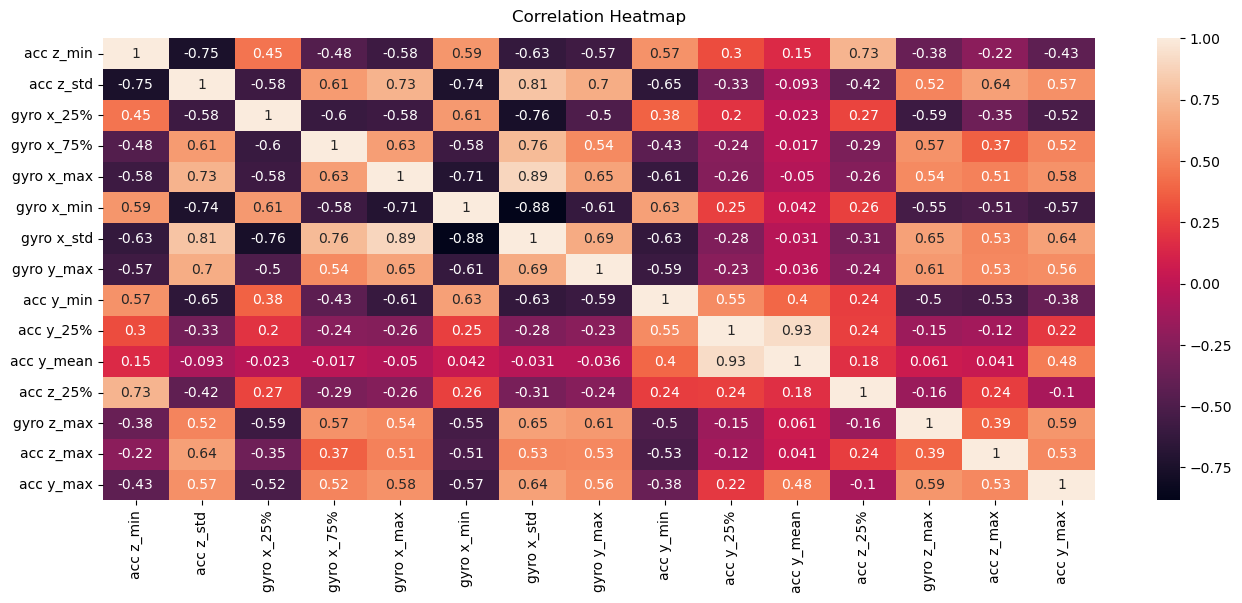

In [90]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_filtered.corr(), annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

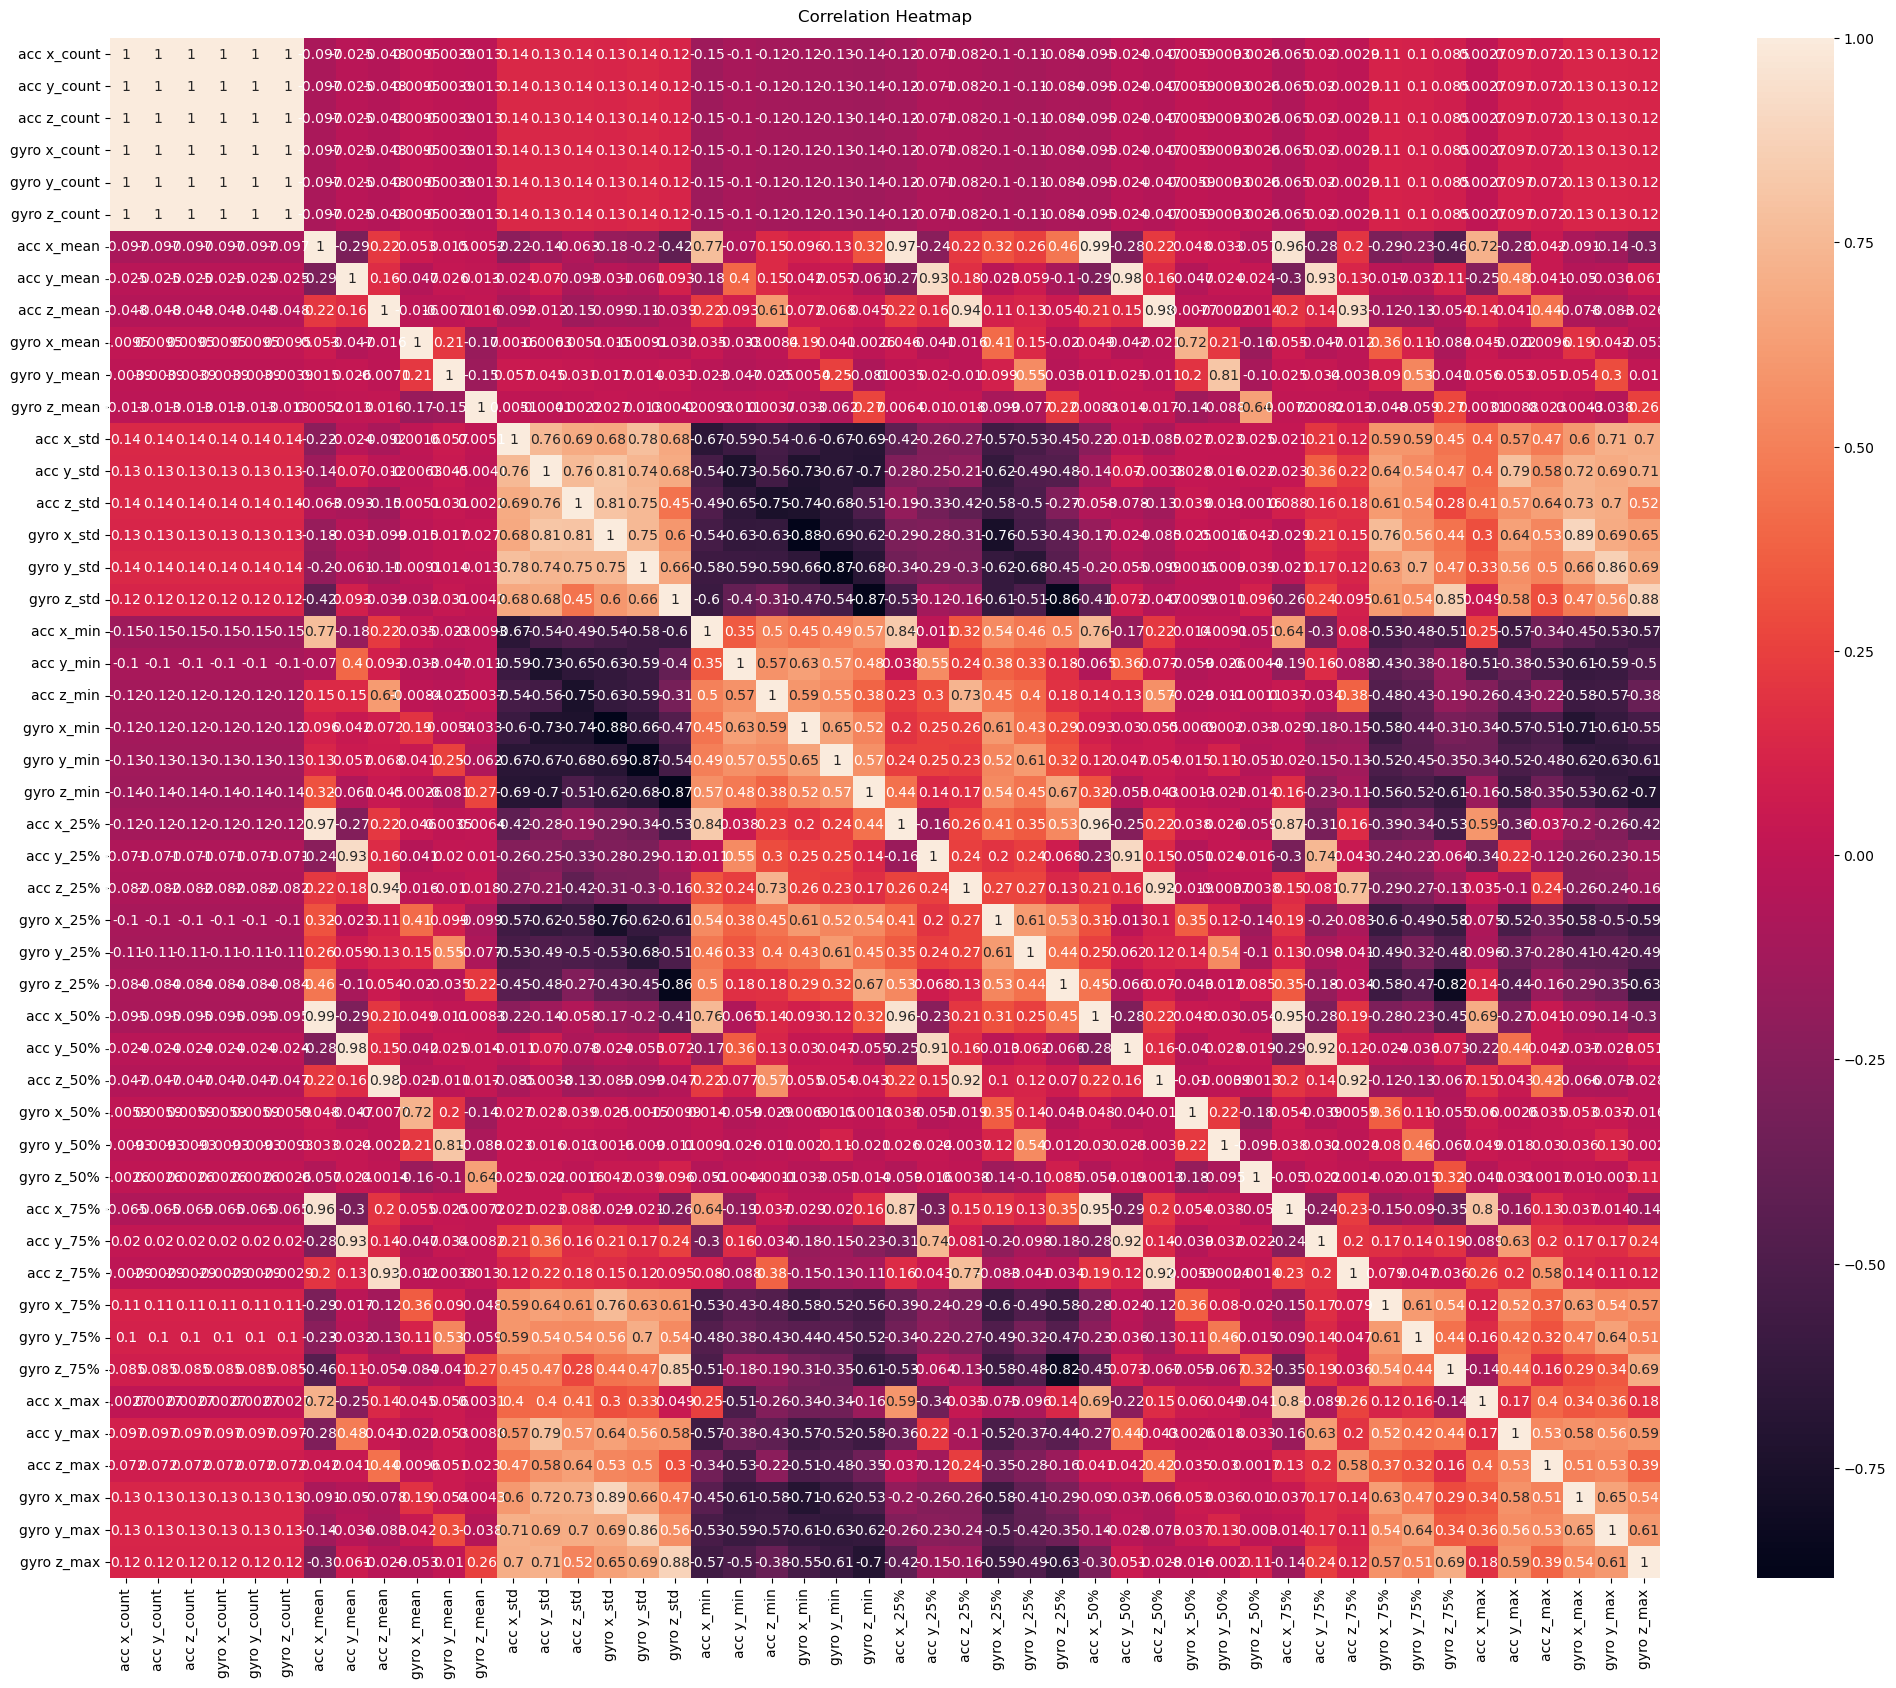

In [124]:
plt.figure(figsize=(25, 20))
heatmap = sns.heatmap(df_stats.corr(), annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [94]:
X.drop(columns=to_drop).head()

,acc x_mean,acc y_mean,acc z_mean,gyro x_mean,gyro y_mean,gyro z_mean,acc x_std
0,-1.398484,2.455087,3.690422,1.383064,-0.361257,-0.327538,1.732644
1,-2.351829,9.059114,-2.582534,0.118003,-0.134537,-0.024264,1.066168
2,-2.428151,7.748591,-4.829813,-0.598094,0.450379,-0.039486,0.814453
3,-3.653698,0.185135,8.919947,-0.363847,0.091019,0.258803,1.548478
4,-2.106436,-2.842761,7.674234,-0.385562,0.055515,-0.137990,1.050062
